# Dependencies

In [ ]:
import os
foundation_path = ""
os.chdir(foundation_path)

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import joblib

from sklearn.preprocessing import MinMaxScaler

from models import LSTM_layer
from torch.utils.data import TensorDataset
from module import MSE_loss, MSE_diff_loss, Trend_loss
from module import rmse, mae, mape
from module import Load_dataset

from chronos import Chronos2Pipeline

# Load Dataset

In [6]:
data_raw = Load_dataset(foundation_path=os.path.join(foundation_path, "Data"))

/home/bxai4/financial/FingFinge/module.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  kospi_raw = yf.download(kospi200_ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/home/bxai4/financial/FingFinge/module.py:33: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_raw = yf.download('^VIX', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [10]:
data = data_raw.copy()

data['orig_date'] = pd.to_datetime(data['orig_date'])
data = data.sort_values('orig_date')

# KOSPI log return
data['KOSPI200_LogRet'] = np.log(data['KOSPI200']) - np.log(data['KOSPI200'].shift(1))

# USD/KRW log return
data['USD_KRW_LogRet'] = np.log(data['USD_KRW']) - np.log(data['USD_KRW'].shift(1))

# interest rate difference
data['DGS10_diff'] = data['DGS10'].diff()

data = data.dropna()

data = data[['orig_date', 'target', 'VIX_Close',
             'KOSPI200_LogRet', 'USD_KRW_LogRet', 'DGS10_diff']].copy()

data = data.rename(columns={'orig_date': 'timestamp'})

data['id'] = 'VKOSPI'

data = data[['id', 'timestamp', 'target',
             'VIX_Close', 'KOSPI200_LogRet', 'USD_KRW_LogRet', 'DGS10_diff']]

# Foundation DL Model(Zero-Shot)

## Set Chroos-2 Pipeline

In [110]:
pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

predict_one_step_list = []

starting_point = data[data['orig_date'] == "2023-01-03"].index[0]
for i in range(starting_point, len(data)):
    # Generate predictions with covariates
    pred_df = pipeline.predict_df(
        data.iloc[-1000:i,],
        prediction_length=1,  # Number of steps to forecast
        quantile_levels=[0.1, 0.5, 0.9],  # Quantiles for probabilistic forecast
        id_column="id",  # Column identifying different time series
        timestamp_column="timestamp",  # Column with datetime information
        target="target",  # Column(s) with time series values to predict
    )
    predict_one_step_list.append(pred_df)

In [111]:
pred_data = pd.concat(predict_one_step_list)
data["orig_date"] = data["orig_date"].astype("datetime64[ns]")
date_starting_point = data[data["orig_date"] == "2023-01-03"].index[0]
pred_data["timestamp"] = data["orig_date"][date_starting_point:].tolist()
pred_data.reset_index(drop=True, inplace=True)

## Figure & Metrics

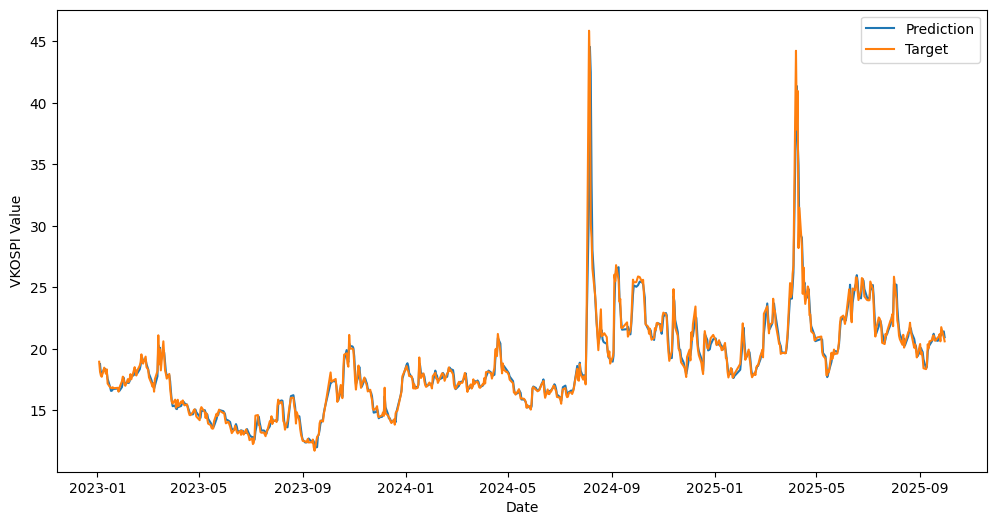

RMSE : 0.9451	 MAE : 0.3941 	 MAPE : 1.8893


In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.plot(pd.DataFrame(pred_data[["timestamp", "predictions"]]).set_index("timestamp"), label = "Prediction")
plt.plot(pd.DataFrame(data_raw[["orig_date", "target"]][date_starting_point:]).reset_index(drop= True).set_index("orig_date"), label = "Target")

plt.xlabel("Date")
plt.ylabel("VKOSPI Value")
plt.legend()
plt.show()

rmse_value = rmse(data_raw["target"][date_starting_point+1:].reset_index(drop=True), pred_data["predictions"])
mae_value = mae(data_raw["target"][date_starting_point+1:].reset_index(drop=True), pred_data["predictions"])
mape_value = mape(data_raw["target"][date_starting_point+1:].reset_index(drop=True), pred_data["predictions"])
print(f"RMSE : {rmse_value:.4f}\t MAE : {mae_value:.4f} \t MAPE : {mape_value:.4f}")

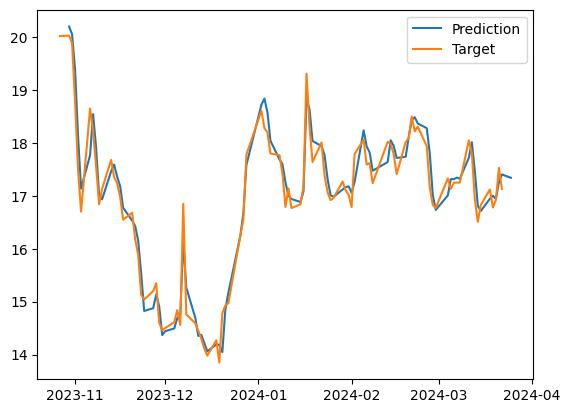

In [113]:
plt.plot(pd.DataFrame(pred_data[["timestamp", "predictions"]]).set_index("timestamp")[200:300], label = "Prediction")
plt.plot(pd.DataFrame(data_raw[["orig_date", "target"]][date_starting_point:]).reset_index(drop= True).set_index("orig_date")[200:300], label = "Target")

plt.legend()
plt.show()

# Simple BiLSTM

In [8]:
data_raw = Load_dataset(foundation_path=os.path.join(foundation_path, "Data"))
data = data_raw.ffill().dropna().reset_index(drop=True)
 
starting_point = data[data['orig_date'] == "2023-01-03"].index[0]
data["target_shift"] = data["target"].shift(-1)

/home/bxai4/financial/FingFinge/module.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  kospi_raw = yf.download(kospi200_ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/home/bxai4/financial/FingFinge/module.py:42: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_raw = yf.download('^VIX', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [28]:
orig_data = data["orig_date"][starting_point:].reset_index(drop= True)
pred_df = pd.concat([orig_data, pd.DataFrame(joblib.load(os.path.join(foundation_path, "Result_pkl", "LSTM_result_no_target.pkl")).values,columns=["predictions"])],axis=1)
pred_df = pred_df.set_index("orig_date")
pred_df

,predictions
orig_date,
2023-01-03,18.381626
2023-01-04,18.983227
2023-01-05,17.897861
2023-01-06,22.228117
2023-01-09,19.208323
...,...
2025-09-24,21.027004
2025-09-25,20.852646
2025-09-26,19.906639


## Figure & Metrics

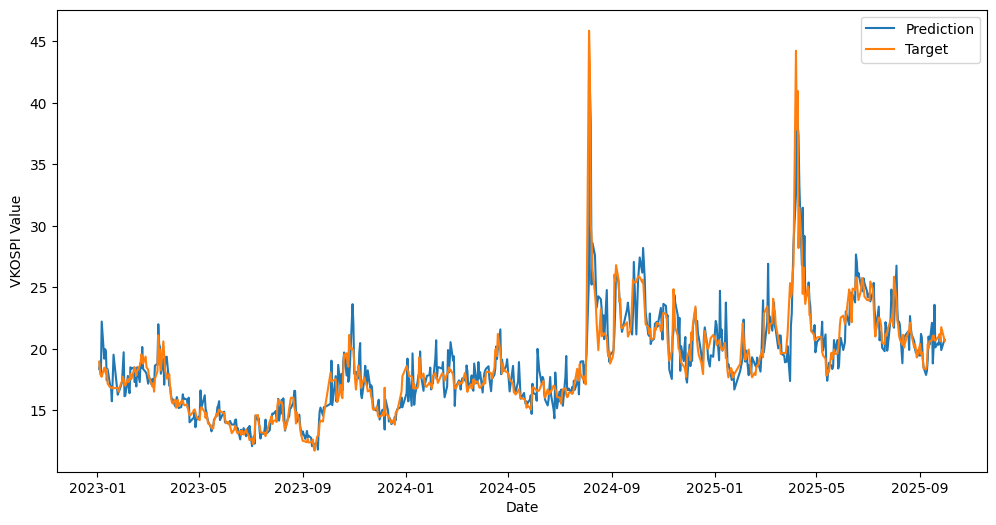

RMSE : 1.6616	 MAE : 1.0069 	 MAPE : 5.0790


In [35]:
import joblib
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.plot(pred_df, label = "Prediction")
plt.plot(pd.DataFrame(data_raw[["orig_date", "target"]][starting_point+1:]).reset_index(drop= True).set_index("orig_date"), label = "Target")

plt.xlabel("Date")
plt.ylabel("VKOSPI Value")
plt.legend()
plt.show()

rmse_value = rmse(data["target_shift"][starting_point-1:].reset_index(drop=True), pred_df["predictions"].reset_index(drop=True))
mae_value = mae(data["target_shift"][starting_point-1:].reset_index(drop=True), pred_df["predictions"].reset_index(drop=True))
mape_value = mape(data["target_shift"][starting_point-1:].reset_index(drop=True), pred_df["predictions"].reset_index(drop=True))
print(f"RMSE : {rmse_value:.4f}\t MAE : {mae_value:.4f} \t MAPE : {mape_value:.4f}")

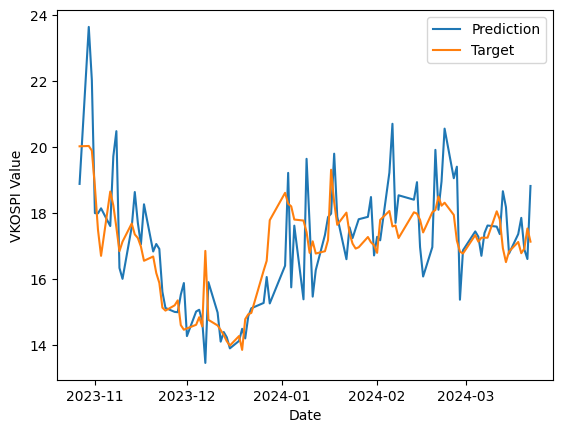

In [31]:
plt.plot(pred_df[200:300], label = "Prediction")
plt.plot(pd.DataFrame(data[["orig_date", "target"]][starting_point:]).reset_index(drop= True).set_index("orig_date")[200:300], label = "Target")

plt.xlabel("Date")
plt.ylabel("VKOSPI Value")
plt.legend()
plt.show()